Downloading the data

In [1]:
# Step 1: Download the dataset
import os
import tarfile
import urllib.request

url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
file_name = "aclImdb_v1.tar.gz"
urllib.request.urlretrieve(url, file_name)

# Step 2: Extract the tar.gz file
if file_name.endswith("tar.gz"):
    with tarfile.open(file_name, "r:gz") as tar:
        tar.extractall()

# Step 3: Remove the 'unsup' directory (Windows-compatible)
unsup_dir = "aclImdb/train/unsup"

# Check if directory exists before removing it
if os.path.exists(unsup_dir):
    import shutil
    shutil.rmtree(unsup_dir)

print("Dataset downloaded, extracted, and 'unsup' directory removed.")


Dataset downloaded, extracted, and 'unsup' directory removed.


In [ ]:
#!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
#!tar -xf aclImdb_v1.tar.gz
#!rm -r aclImdb/train/unsup

Preparing the data

In [2]:
import os, pathlib, shutil, random
from tensorflow import keras
batch_size = 32
base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"
for category in ("neg", "pos"):
    # Add exist_ok=True to avoid the error if the directory already exists to re run code
    os.makedirs(val_dir / category, exist_ok=True)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)
text_only_train_ds = train_ds.map(lambda x, y: x)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


### Base Model

Preparing integer sequence datasets

In [3]:
from tensorflow.keras import layers

max_length = 600
max_tokens = 20000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

A sequence model built on one-hot encoded vector sequences

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define max_tokens
max_tokens = 20000

# Define model
inputs = tf.keras.Input(shape=(None,), dtype="int64")
# Embed each integer token using an Embedding layer
# This will give you a 3D tensor (batch_size, sequence_length, embedding_dim)
embedded = layers.Embedding(input_dim=max_tokens, output_dim=128)(inputs)
# Now the output of the embedding layer is 3D, suitable for the LSTM
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,601,281 (9.92 MB)

 Trainable params: 2,601,281 (9.92 MB)

 Non-trainable params: 0 (0.00 B)

Training a first basic sequence model

In [5]:
callbacks = [
    keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras",
                                    save_best_only=True)
]
history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("one_hot_bidir_lstm.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 43ms/step - accuracy: 0.6288 - loss: 0.6238 - val_accuracy: 0.8412 - val_loss: 0.3916
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 41ms/step - accuracy: 0.8345 - loss: 0.4113 - val_accuracy: 0.8682 - val_loss: 0.3301
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.8788 - loss: 0.3222 - val_accuracy: 0.8734 - val_loss: 0.3391
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.8945 - loss: 0.2919 - val_accuracy: 0.8226 - val_loss: 0.3938
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.9119 - loss: 0.2495 - val_accuracy: 0.8092 - val_loss: 0.4552
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.9246 - loss: 0.2240 - val_accuracy: 0.8314 - val_loss: 0.4772
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.9357 - loss: 0.1923 - val_accuracy: 0.8180 - val_loss: 0.5650
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.9402 - loss: 0.1798 - 

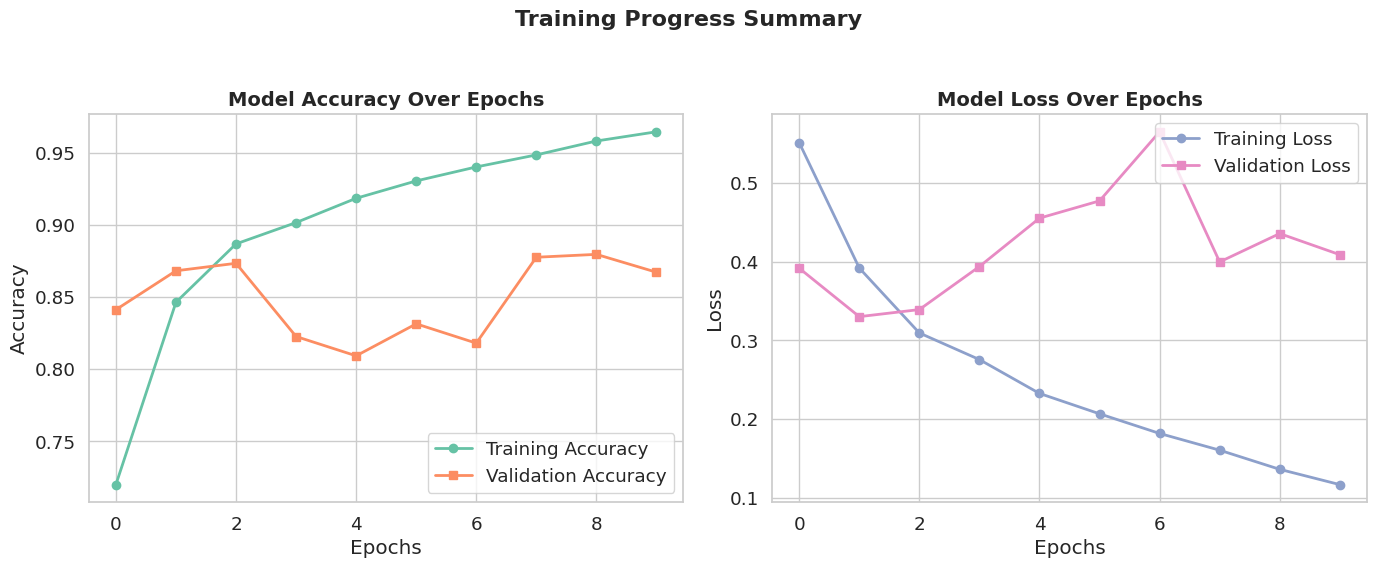

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a modern Seaborn style
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# Define custom color palette
colors = sns.color_palette("Set2")

# Plotting the training and validation accuracy/loss
plt.figure(figsize=(14, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color=colors[0], linewidth=2, marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color=colors[1], linewidth=2, marker='s')
plt.title('Model Accuracy Over Epochs', fontsize=14, weight='bold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color=colors[2], linewidth=2, marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', color=colors[3], linewidth=2, marker='s')
plt.title('Model Loss Over Epochs', fontsize=14, weight='bold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.suptitle('Training Progress Summary', fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Question 1

In [8]:
# Set the maximum number of tokens in each review after truncation
max_len_review = 150

# Create a new TextVectorization layer with custom settings
custom_vectorizer = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_len_review  # Limit each sequence to 150 tokens
)

# Adapt vectorizer using the raw text data
custom_vectorizer.adapt(text_only_train_ds)

# Vectorize all datasets (train, validation, and test) using the new vectorizer
train_ds_vectorized = train_ds.map(
    lambda text, label: (custom_vectorizer(text), label),
    num_parallel_calls=tf.data.AUTOTUNE)

val_ds_vectorized = val_ds.map(
    lambda text, label: (custom_vectorizer(text), label),
    num_parallel_calls=tf.data.AUTOTUNE)

test_ds_vectorized = test_ds.map(
    lambda text, label: (custom_vectorizer(text), label),
    num_parallel_calls=tf.data.AUTOTUNE)

# Build a Sequential model with an Embedding and Bidirectional LSTM
model_with_limit150 = tf.keras.Sequential([
    layers.Embedding(input_dim=max_tokens, output_dim=128, input_length=max_len_review),
    layers.Bidirectional(layers.LSTM(units=32)),
    layers.Dropout(rate=0.5),
    layers.Dense(units=1, activation="sigmoid")
])

# Compile the model with appropriate optimizer and loss function
model_with_limit150.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Use a callback to save the best-performing model during training
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    filepath="bi_lstm_model_150.keras",
    save_best_only=True
)

# Train the model on the vectorized dataset
history_model150 = model_with_limit150.fit(
    train_ds_vectorized,
    validation_data=val_ds_vectorized,
    epochs=10,
    callbacks=[checkpoint_cb]
)

# Evaluate performance on the test set and print accuracy
test_loss, test_accuracy = model_with_limit150.evaluate(test_ds_vectorized)
print(f"Accuracy on test data: {test_accuracy:.3f}")


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.6282 - loss: 0.6203 - val_accuracy: 0.8242 - val_loss: 0.4112
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.8315 - loss: 0.4079 - val_accuracy: 0.8408 - val_loss: 0.3654
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.8709 - loss: 0.3263 - val_accuracy: 0.8426 - val_loss: 0.3533
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.8991 - loss: 0.2718 - val_accuracy: 0.8246 - val_loss: 0.4630
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.9160 - loss: 0.2343 - val_accuracy: 0.8544 - val_loss: 0.4543
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.9319 - loss: 0.2001 - val_accuracy: 0.8218 - val_loss: 0.4777
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.9453 - loss: 0.1620 - val_accuracy: 0.8426 - val_loss: 0.4818
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.9604 - loss: 0.1215 - val_accurac

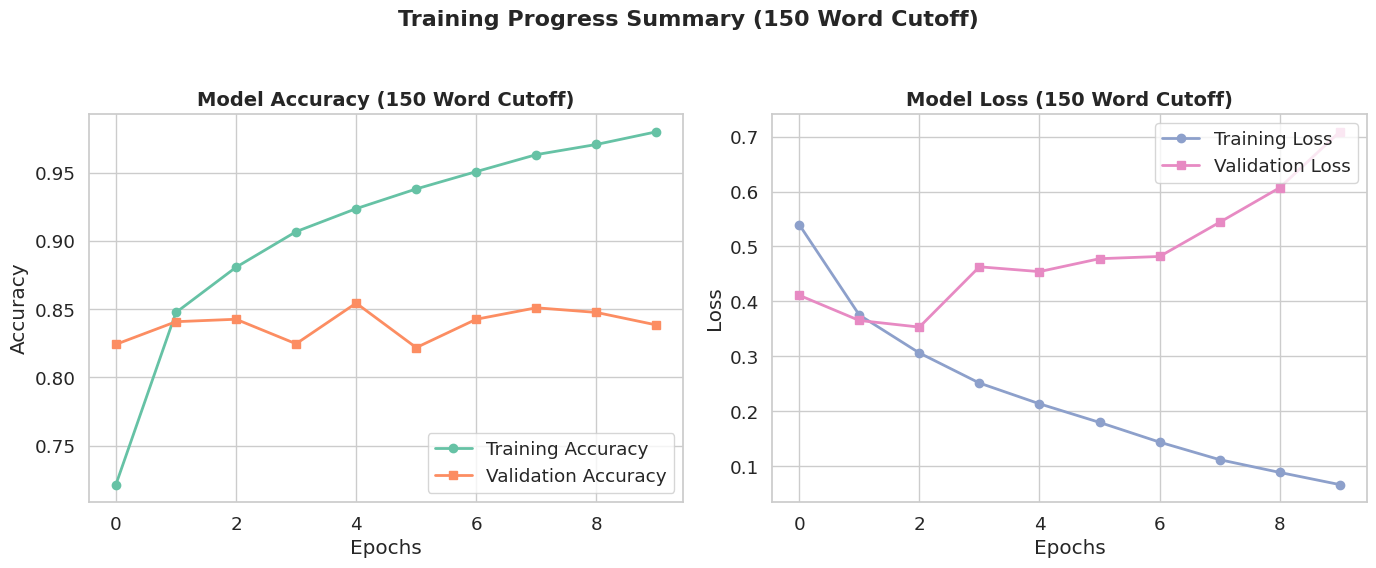

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a modern Seaborn style
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# Define custom color palette
colors = sns.color_palette("Set2")

# Plotting the training and validation accuracy/loss
plt.figure(figsize=(14, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_model150.history['accuracy'], label='Training Accuracy', color=colors[0], linewidth=2, marker='o')
plt.plot(history_model150.history['val_accuracy'], label='Validation Accuracy', color=colors[1], linewidth=2, marker='s')
plt.title('Model Accuracy (150 Word Cutoff)', fontsize=14, weight='bold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_model150.history['loss'], label='Training Loss', color=colors[2], linewidth=2, marker='o')
plt.plot(history_model150.history['val_loss'], label='Validation Loss', color=colors[3], linewidth=2, marker='s')
plt.title('Model Loss (150 Word Cutoff)', fontsize=14, weight='bold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.suptitle('Training Progress Summary (150 Word Cutoff)', fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Question 2

In [10]:
# Step 1: Restrict training to 100 samples
train_ds_small = train_ds_vectorized.take(100)  # Only 100 samples

# Step 2: Define model (same architecture)
model_small_sample = tf.keras.Sequential([
    layers.Embedding(input_dim=max_tokens, output_dim=128, input_length=max_len_review),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
])

# Step 3: Compile
model_small_sample.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Step 4: Train
history_small_sample = model_small_sample.fit(
    train_ds_small,
    validation_data=val_ds_vectorized,
    epochs=10
)

# Step 5: Evaluate on test data
test_loss, test_acc = model_small_sample.evaluate(test_ds_vectorized)
print(f"Test accuracy: {test_acc:.3f}")


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.5175 - loss: 0.6923 - val_accuracy: 0.5658 - val_loss: 0.6859
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6466 - loss: 0.6520 - val_accuracy: 0.7144 - val_loss: 0.5742
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.7729 - loss: 0.5056 - val_accuracy: 0.7496 - val_loss: 0.5157
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8521 - loss: 0.3826 - val_accuracy: 0.7826 - val_loss: 0.4792
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.8982 - loss: 0.2876 - val_accuracy: 0.7978 - val_loss: 0.4689
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9249 - loss: 0.2169 - val_accuracy: 0.7902 - val_loss: 0.4832
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9470 - loss: 0.1561 - val_accuracy: 0.7728 - val_loss: 0.4963
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9674 - loss: 0.1044 - val_accu

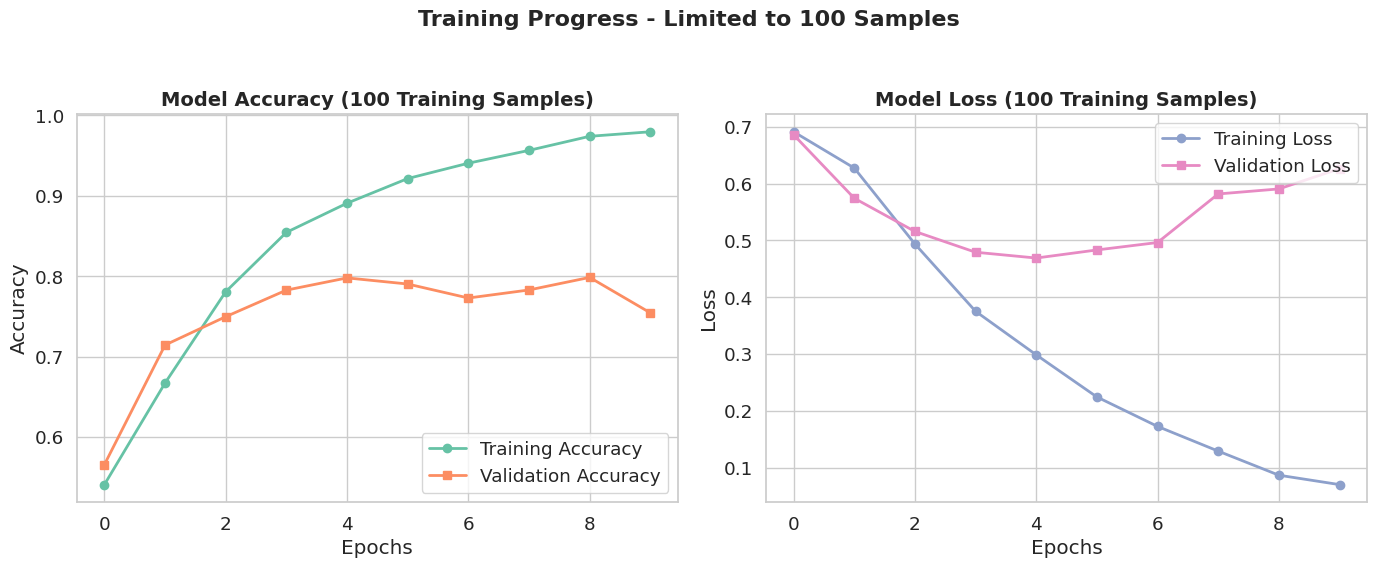

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a clean Seaborn style
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# Use a nice color palette
colors = sns.color_palette("Set2")

# Plotting the training and validation accuracy/loss
plt.figure(figsize=(14, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_small_sample.history['accuracy'], label='Training Accuracy', color=colors[0], linewidth=2, marker='o')
plt.plot(history_small_sample.history['val_accuracy'], label='Validation Accuracy', color=colors[1], linewidth=2, marker='s')
plt.title('Model Accuracy (100 Training Samples)', fontsize=14, weight='bold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_small_sample.history['loss'], label='Training Loss', color=colors[2], linewidth=2, marker='o')
plt.plot(history_small_sample.history['val_loss'], label='Validation Loss', color=colors[3], linewidth=2, marker='s')
plt.title('Model Loss (100 Training Samples)', fontsize=14, weight='bold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.suptitle('Training Progress - Limited to 100 Samples', fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Question 3

In [12]:
# Limit the validation dataset to 10,000 samples
val_ds_limited = val_ds_vectorized.take(10000)

# Build the model
model_validation_10k = tf.keras.Sequential([
    layers.Embedding(input_dim=max_tokens, output_dim=128, input_length=max_len_review),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid"),
])

# Compile the model
model_validation_10k.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Train the model with the 10,000-sample validation set
history_validation_10k = model_validation_10k.fit(
    train_ds_vectorized,
    validation_data=val_ds_limited,
    epochs=10
)

# Evaluate model performance on the test set
test_loss, test_accuracy = model_validation_10k.evaluate(test_ds_vectorized)
print(f"Test accuracy with validation=10K: {test_accuracy:.3f}")


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.6430 - loss: 0.6149 - val_accuracy: 0.8294 - val_loss: 0.3892
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.8367 - loss: 0.3970 - val_accuracy: 0.8290 - val_loss: 0.4169
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.8779 - loss: 0.3228 - val_accuracy: 0.7908 - val_loss: 0.5593
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.8975 - loss: 0.2763 - val_accuracy: 0.8506 - val_loss: 0.4536
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.9149 - loss: 0.2325 - val_accuracy: 0.8548 - val_loss: 0.3907
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.9264 - loss: 0.2063 - val_accuracy: 0.8542 - val_loss: 0.4770
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.9437 - loss: 0.1678 - val_accuracy: 0.8484 - val_loss: 0.4607
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.9525 - loss: 0.1409 - 

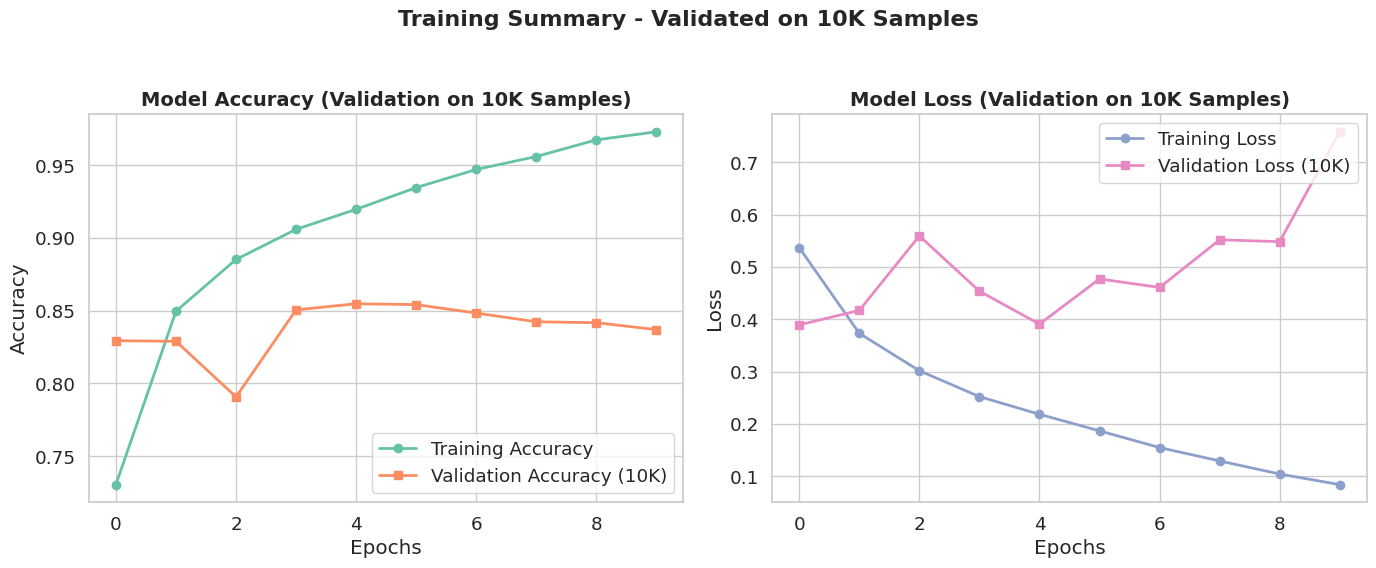

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Styling
sns.set(style="whitegrid", palette="muted", font_scale=1.2)
colors = sns.color_palette("Set2")

# Create side-by-side plots
plt.figure(figsize=(14, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_validation_10k.history['accuracy'], label='Training Accuracy', color=colors[0], linewidth=2, marker='o')
plt.plot(history_validation_10k.history['val_accuracy'], label='Validation Accuracy (10K)', color=colors[1], linewidth=2, marker='s')
plt.title('Model Accuracy (Validation on 10K Samples)', fontsize=14, weight='bold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_validation_10k.history['loss'], label='Training Loss', color=colors[2], linewidth=2, marker='o')
plt.plot(history_validation_10k.history['val_loss'], label='Validation Loss (10K)', color=colors[3], linewidth=2, marker='s')
plt.title('Model Loss (Validation on 10K Samples)', fontsize=14, weight='bold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

# Overall title
plt.suptitle('Training Summary - Validated on 10K Samples', fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Question 4

In [14]:
# Set max_tokens to 10,000 to limit vocabulary
max_tokens_top_10k = 10000

# Create new TextVectorization layer
vectorizer_top_10k = layers.TextVectorization(
    max_tokens=max_tokens_top_10k,
    output_mode="int",
    output_sequence_length=max_len_review  # use same review length
)

# Adapt the vectorizer using training-only text data
vectorizer_top_10k.adapt(text_only_train_ds)

# Vectorize datasets
train_ds_top_10k = train_ds.map(
    lambda x, y: (vectorizer_top_10k(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
)
val_ds_top_10k = val_ds.map(
    lambda x, y: (vectorizer_top_10k(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
)
test_ds_top_10k = test_ds.map(
    lambda x, y: (vectorizer_top_10k(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
)
# Define the model
model_top_words = tf.keras.Sequential([
    layers.Embedding(input_dim=max_tokens_top_10k, output_dim=128, input_length=max_len_review),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid"),
])

# Compile the model
model_top_words.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
# Train the model on the new top 10K word dataset
history_top_words = model_top_words.fit(
    train_ds_top_10k,
    validation_data=val_ds_top_10k,
    epochs=10
)
# Evaluate on test set
test_loss, test_accuracy = model_top_words.evaluate(test_ds_top_10k)
print(f"Test accuracy with top 10,000 words: {test_accuracy:.3f}")


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.6342 - loss: 0.6229 - val_accuracy: 0.8238 - val_loss: 0.3958
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.8257 - loss: 0.4178 - val_accuracy: 0.8344 - val_loss: 0.3722
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.8648 - loss: 0.3425 - val_accuracy: 0.8462 - val_loss: 0.3801
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.8871 - loss: 0.2943 - val_accuracy: 0.8460 - val_loss: 0.3885
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.9041 - loss: 0.2570 - val_accuracy: 0.8426 - val_loss: 0.4459
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.9206 - loss: 0.2248 - val_accuracy: 0.8440 - val_loss: 0.4332
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.9345 - loss: 0.1869 - val_accuracy: 0.8430 - val_loss: 0.4863
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.9476 - loss: 0.1563 - 

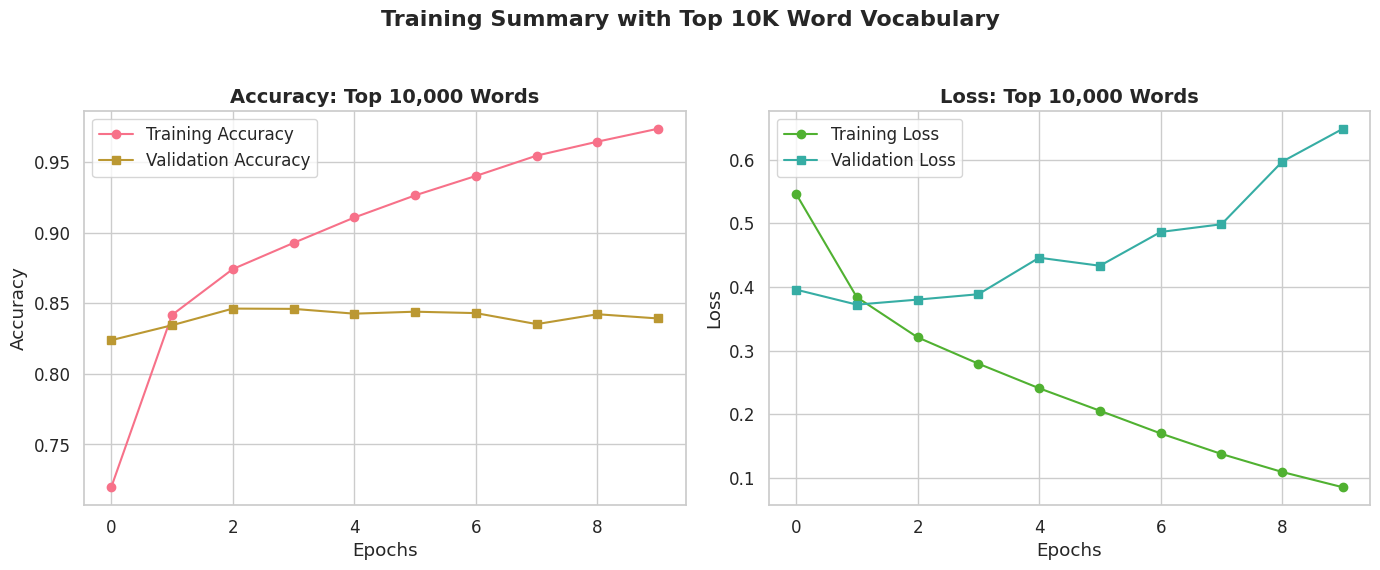

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Style setup
sns.set(style="whitegrid", font_scale=1.1)
colors = sns.color_palette("husl")

# Create plots
plt.figure(figsize=(14, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_top_words.history['accuracy'], label='Training Accuracy', color=colors[0], marker='o')
plt.plot(history_top_words.history['val_accuracy'], label='Validation Accuracy', color=colors[1], marker='s')
plt.title("Accuracy: Top 10,000 Words", fontsize=14, weight='bold')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_top_words.history['loss'], label='Training Loss', color=colors[2], marker='o')
plt.plot(history_top_words.history['val_loss'], label='Validation Loss', color=colors[3], marker='s')
plt.title("Loss: Top 10,000 Words", fontsize=14, weight='bold')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Overall layout
plt.suptitle("Training Summary with Top 10K Word Vocabulary", fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Question 5

Preparing pre trained model

In [17]:
import os
import tarfile
import urllib.request
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import initializers

# Step 1: Download the IMDB dataset
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
file_name = "aclImdb_v1.tar.gz"
if not os.path.exists("aclImdb"):
    urllib.request.urlretrieve(url, file_name)
    with tarfile.open(file_name, "r:gz") as tar:
        tar.extractall()
    print("IMDB dataset downloaded and extracted.")

# Step 2: Remove the 'unsup' directory
unsup_dir = "aclImdb/train/unsup"
if os.path.exists(unsup_dir):
    import shutil
    shutil.rmtree(unsup_dir)
print("'unsup' directory removed.")

# Step 3: Download and extract GloVe embeddings
glove_zip = "glove.6B.zip"
glove_url = "http://nlp.stanford.edu/data/glove.6B.zip"
glove_txt_file = "glove.6B.100d.txt"

if not os.path.exists(glove_txt_file):
    if not os.path.exists(glove_zip):
        print("Downloading GloVe embeddings...")
        urllib.request.urlretrieve(glove_url, glove_zip)
    with zipfile.ZipFile(glove_zip, "r") as zip_ref:
        zip_ref.extract(glove_txt_file)
    print("GloVe embeddings extracted.")

# Step 4: Load GloVe vectors
embeddings_index = {}
with open(glove_txt_file, encoding="utf-8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        embeddings_index[word] = np.fromstring(coefs, "f", sep=" ")
print(f"Found {len(embeddings_index)} word vectors.")

# Step 5: Simulated vocabulary for example
vocabulary = ["the", "and", "movie", "good", "bad", "great"]
word_index = dict(zip(vocabulary, range(len(vocabulary))))

# Step 6: Create embedding matrix
max_tokens = 20000
embedding_dim = 100
embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Step 7: Define embedding layers
embedding_layer_trained = layers.Embedding(
    max_tokens,
    embedding_dim,
    input_length=200
)

embedding_layer_pretrained = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True
)

print("Embedding layers defined.")


'unsup' directory removed.
GloVe embeddings extracted.
Found 400000 word vectors.
Embedding layers defined.


In [18]:
# Load IMDB dataset from TensorFlow
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=32, validation_split=0.2, subset="training", seed=42
)
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=32, validation_split=0.2, subset="validation", seed=42
)
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=32
)

# Create TextVectorization layer
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=200  # Use 200 as the sequence length
)

# Adapt the TextVectorization layer to the training text
text_vectorization.adapt(raw_train_ds.map(lambda x, y: x))

# Vectorize datasets
def vectorize_text(text, label):
    return text_vectorization(text), label

int_train_ds = raw_train_ds.map(vectorize_text)
int_val_ds = raw_val_ds.map(vectorize_text)
int_test_ds = raw_test_ds.map(vectorize_text)

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
int_train_ds = int_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
int_val_ds = int_val_ds.cache().prefetch(buffer_size=AUTOTUNE)
int_test_ds = int_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("IMDB dataset loaded and processed.")


Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.
IMDB dataset loaded and processed.


In [19]:
# Build a model using the trained embedding layer
inputs = tf.keras.Input(shape=(None,), dtype="int64")
x = embedding_layer_trained(inputs)  # Trained embeddings
x = layers.Bidirectional(layers.LSTM(32))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_trained = tf.keras.Model(inputs, outputs)
model_trained.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
history_trained = model_trained.fit(int_train_ds, validation_data=int_val_ds, epochs=10)

# Evaluate the model
test_acc_trained = model_trained.evaluate(int_test_ds)[1]
print(f"Test accuracy (Trained Embedding): {test_acc_trained:.3f}")


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.6337 - loss: 0.6180 - val_accuracy: 0.8334 - val_loss: 0.4019
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.8377 - loss: 0.3956 - val_accuracy: 0.8600 - val_loss: 0.3482
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.8801 - loss: 0.3091 - val_accuracy: 0.8628 - val_loss: 0.3501
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9034 - loss: 0.2594 - val_accuracy: 0.8612 - val_loss: 0.3539
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9218 - loss: 0.2244 - val_accuracy: 0.8592 - val_loss: 0.3478
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.9365 - loss: 0.1920 - val_accuracy: 0.8530 - val_loss: 0.3591
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9425 - loss: 0.1689 - val_accuracy: 0.8574 - val_loss: 0.3856
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.9504 - loss: 0.1488 - 

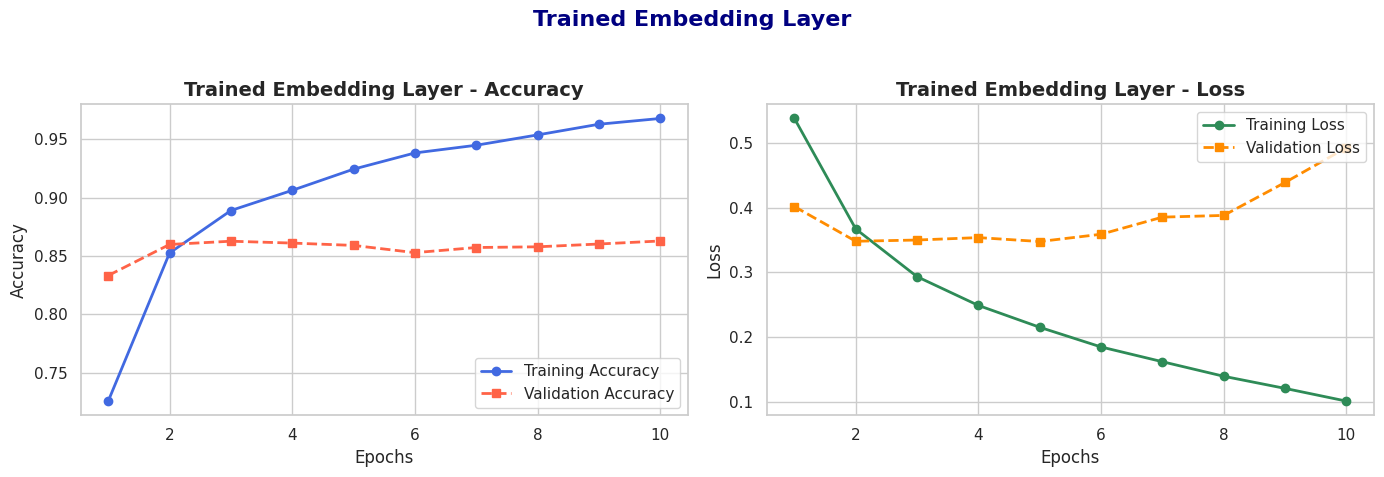

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a clean, modern style
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 12})

def fancy_plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy Plot
    axes[0].plot(epochs, acc, 'o-', label='Training Accuracy', color='royalblue', linewidth=2)
    axes[0].plot(epochs, val_acc, 's--', label='Validation Accuracy', color='tomato', linewidth=2)
    axes[0].set_title(f"{title} - Accuracy", fontsize=14, weight='bold')
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Accuracy")
    axes[0].legend(loc="lower right")
    axes[0].grid(True)

    # Loss Plot
    axes[1].plot(epochs, loss, 'o-', label='Training Loss', color='seagreen', linewidth=2)
    axes[1].plot(epochs, val_loss, 's--', label='Validation Loss', color='darkorange', linewidth=2)
    axes[1].set_title(f"{title} - Loss", fontsize=14, weight='bold')
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Loss")
    axes[1].legend(loc="upper right")
    axes[1].grid(True)

    plt.suptitle(title, fontsize=16, weight='bold', color='navy')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Plot Trained Embedding First
fancy_plot_history(history_trained, "Trained Embedding Layer")


In [21]:
# ----------------------------------------
# Step 8: Load IMDB dataset using Keras utility
# ----------------------------------------
batch_size = 32
seed = 42

# Use validation split by moving 10,000 from training set
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=seed
)
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=seed
)
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    "aclImdb/test",
    batch_size=batch_size
)

# ----------------------------------------
# Step 9: Prepare TextVectorization
# ----------------------------------------
text_vectorizer = layers.TextVectorization(max_tokens=max_tokens, output_sequence_length=200)
text_vectorizer.adapt(raw_train_ds.map(lambda x, y: x))  # Fit only on training text

# Create new word_index from vectorizer vocab
vocabulary = text_vectorizer.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

# ----------------------------------------
# Step 10: Build embedding matrix from GloVe
# ----------------------------------------
embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# ----------------------------------------
# Step 11: Define Pretrained Embedding Layer
# ----------------------------------------
embedding_layer_pretrained = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True
)

# ----------------------------------------
# Step 12: Preprocess Datasets
# ----------------------------------------
def vectorize_text(text, label):
    return text_vectorizer(text), label

train_ds = raw_train_ds.map(vectorize_text).cache().prefetch(tf.data.AUTOTUNE)
val_ds = raw_val_ds.map(vectorize_text).cache().prefetch(tf.data.AUTOTUNE)
test_ds = raw_test_ds.map(vectorize_text).cache().prefetch(tf.data.AUTOTUNE)

# ----------------------------------------
# Step 13: Build and Compile Pretrained Model
# ----------------------------------------
inputs = tf.keras.Input(shape=(None,), dtype="int64")
x = embedding_layer_pretrained(inputs)
x = layers.Bidirectional(layers.LSTM(32))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_pretrained = tf.keras.Model(inputs, outputs)
model_pretrained.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# ----------------------------------------
# Step 14: Train Pretrained Model
# ----------------------------------------
history_pretrained = model_pretrained.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

# ----------------------------------------
# Step 15: Evaluate on Test Set
# ----------------------------------------
test_loss, test_acc = model_pretrained.evaluate(test_ds)
print(f"Test Accuracy (Pretrained Embedding): {test_acc:.3f}")


Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.
Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.5165 - loss: 0.7042 - val_accuracy: 0.6098 - val_loss: 0.6657
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.6108 - loss: 0.6542 - val_accuracy: 0.7136 - val_loss: 0.5678
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.7237 - loss: 0.5647 - val_accuracy: 0.7362 - val_loss: 0.5350
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.7444 - loss: 0.5323 - val_accuracy: 0.7480 - val_loss: 0.5143
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.7660 - loss: 0.5051 - val_accuracy: 0.7676 - val_loss: 0.4940
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.7736 - loss: 0.4884 - val_accuracy: 0.7754 - val_loss: 0.4778
Epoch 7/10
625/625 ━━━━━━━━━━

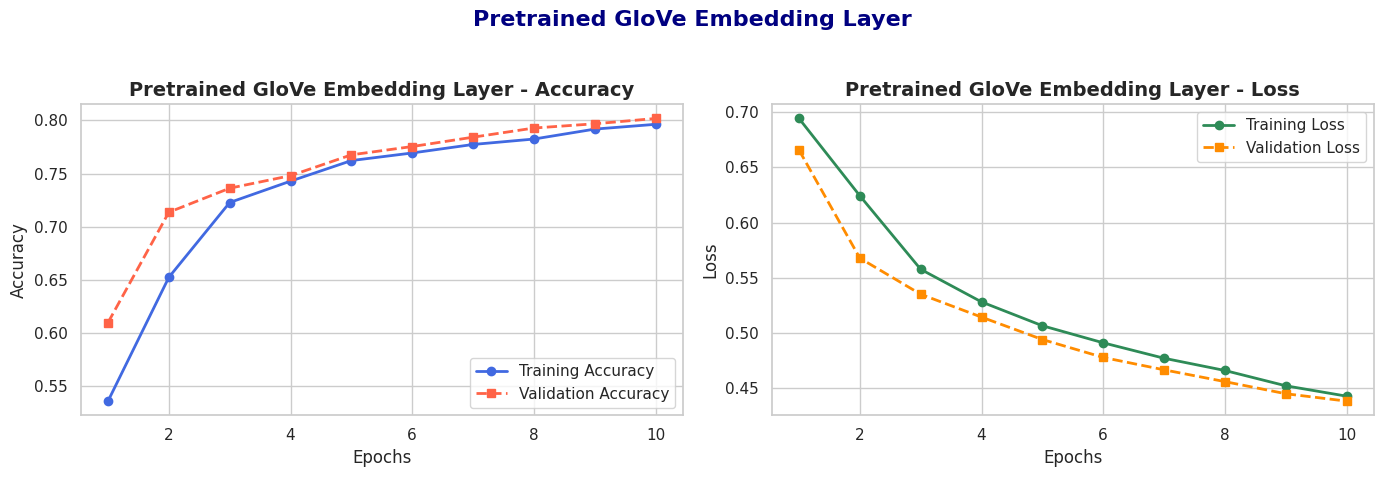

In [22]:
fancy_plot_history(history_pretrained, "Pretrained GloVe Embedding Layer")


Increasing Values

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.7785 - loss: 0.4957 - val_accuracy: 0.8398 - val_loss: 0.4204
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9736 - loss: 0.1232 - val_accuracy: 0.8388 - val_loss: 0.4908
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9943 - loss: 0.0432 - val_accuracy: 0.8322 - val_loss: 0.6092
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9949 - loss: 0.0289 - val_accuracy: 0.8370 - val_loss: 0.6670
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9925 - loss: 0.0360 - val_accuracy: 0.8256 - val_loss: 0.8234
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9884 - loss: 0.0431 - val_accuracy: 0.8394 - val_loss: 0.7779
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9934 - loss: 0.0174 - val_accuracy: 0.8344 - val_loss: 0.8681
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9937 - loss: 0.0228 - val_accu

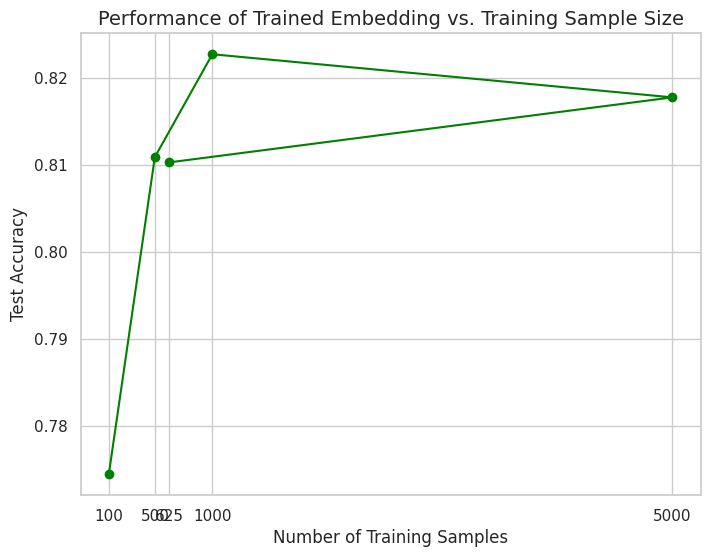

In [26]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Define training sample sizes (adjust based on your total dataset size if needed)
training_sample_sizes = [100, 500, 1000, 5000, len(int_train_ds)]

# Store test accuracy for each sample size
trained_embedding_accuracies = []

for size in training_sample_sizes:
    # Take the first 'size' samples from int_train_ds
    partial_train_ds = int_train_ds.take(size)

    # Build a new model using your trained embedding layer
    inputs = tf.keras.Input(shape=(None,), dtype="int64")
    x = embedding_layer_trained(inputs)  # Your embedding layer trained from scratch
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

    # Train the model on current subset
    model.fit(partial_train_ds, validation_data=int_val_ds, epochs=10)

    # Evaluate on the full test set
    test_loss, test_acc = model.evaluate(int_test_ds)
    trained_embedding_accuracies.append(test_acc)

    print(f"Training samples: {size}, Test Accuracy (Trained Embedding): {test_acc:.3f}")

# Display all results
print("\nFinal Results:")
for size, acc in zip(training_sample_sizes, trained_embedding_accuracies):
    print(f"Training size: {size}, Test accuracy: {acc:.3f}")

# Plot the curve
plt.figure(figsize=(8, 6))
plt.plot(training_sample_sizes, trained_embedding_accuracies, marker='o', linestyle='-', color='green')
plt.title("Performance of Trained Embedding vs. Training Sample Size", fontsize=14)
plt.xlabel("Number of Training Samples", fontsize=12)
plt.ylabel("Test Accuracy", fontsize=12)
plt.grid(True)
plt.xticks(training_sample_sizes)
plt.show()
